# Number of Bike Points in London boroughs

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import requests
import json
import pandas as pd

## Map of London boroughs

In [3]:
ward = gpd.read_file('./data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
ward.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


## Location of Bike Points

In [4]:
# Make GET request
response = requests.get("https://api.tfl.gov.uk/BikePoint/")

# Convert the raw Unicode content to a character string, then parse it as JSON
data = json.loads(response.content.decode("utf-8"))

# Extract relevant variables from the bikepoints data
data_bp = [{"id": item["id"], "commonName": item["commonName"], "lat": item["lat"], "lon": item["lon"]} for item in data]

# Convert to data frame
data_bp_df = pd.DataFrame(data_bp)

# Display the resulting DataFrame
data_bp_df.head()


,id,commonName,lat,lon
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970
1,BikePoints_2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,BikePoints_3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,BikePoints_4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,BikePoints_5,"Sedding Street, Sloane Square",51.493130,-0.156876


In [7]:
geometry=gpd.points_from_xy(data_bp_df.lon, data_bp_df.lat)

In [8]:
# Create a GeoDataFrame from data_bp_df
data_bp_gdf = gpd.GeoDataFrame(data_bp_df, geometry=geometry, crs="EPSG:4326")


In [9]:
# adjust reference system
data_bp_gdf.to_crs(epsg='27700', inplace=True)
ward.to_crs(epsg='27700', inplace=True)

## Map of London boroughs with BikePoints

(173000.0, 187000.0)

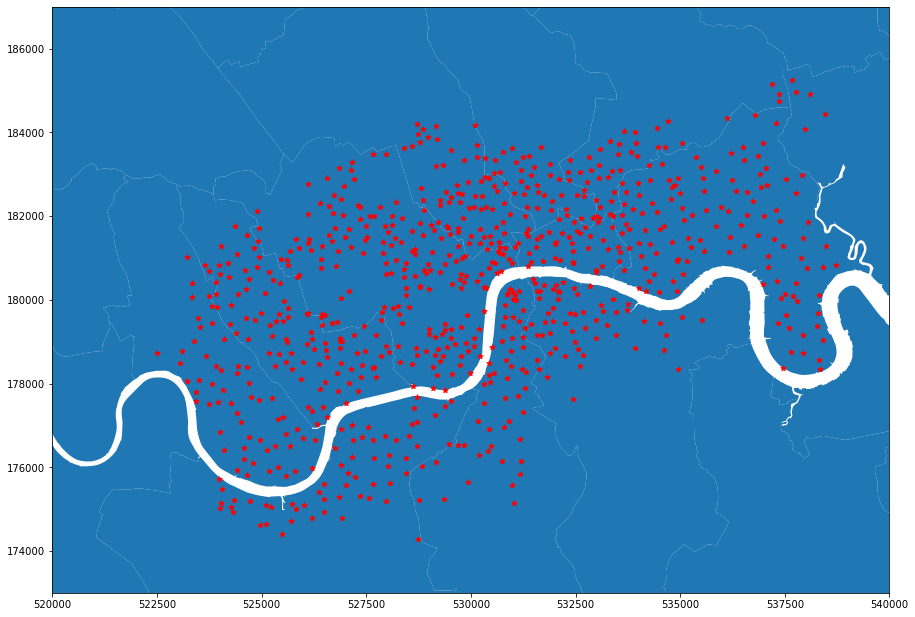

In [10]:
fig,ax = plt.subplots(figsize = (15,15))
#ward.to_crs(epsg='27700', inplace=True)
ward.plot(ax = ax)
data_bp_gdf.plot(ax = ax, markersize = 30, color = 'red',marker = '*')

# display zoomed image, setting axis limits
xmin = 520000
xmax = 540000
ymin = 173000
ymax = 187000

# Set x-axis and y-axis limits 
ax.set_xlim(xmin, xmax)  # Specify the minimum and maximum x-axis values
ax.set_ylim(ymin, ymax)  # Specify the minimum and maximum y-axis values

In [11]:
# Spatial join to find points within polygons
pointsInPolygon = gpd.sjoin(data_bp_gdf, ward)

# Group by an attribute (e.g., state name) and count the points
points_count_by_attribute = pointsInPolygon.groupby(['NAME']).size()

print("Number of points within each polygon:")
points_count_by_attribute.head()

Number of points within each polygon:


NAME
Camden                    64
City of London            37
Hackney                   39
Hammersmith and Fulham    58
Islington                 35
dtype: int64

## Number of BikePoints by Borough

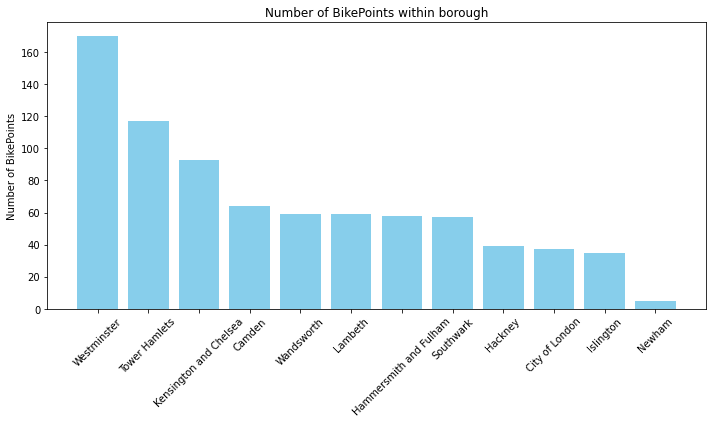

In [12]:
ward_names = points_count_by_attribute.index
point_counts = points_count_by_attribute.values

# Sort the data by point count (descending order)
sorted_indices = point_counts.argsort()[::-1]
sorted_ward_names = ward_names[sorted_indices]
sorted_point_counts = point_counts[sorted_indices]


# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_ward_names, sorted_point_counts, color='skyblue')
plt.xlabel('')
plt.ylabel('Number of BikePoints')
plt.title('Number of BikePoints within borough')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()